E in = 0.000000
E out = 0.126000


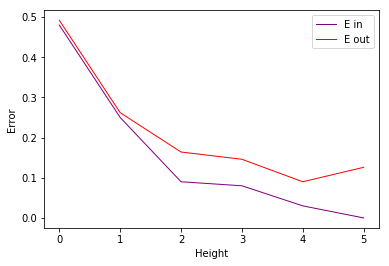

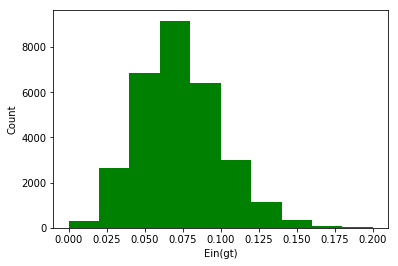

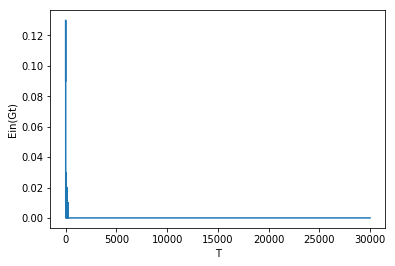

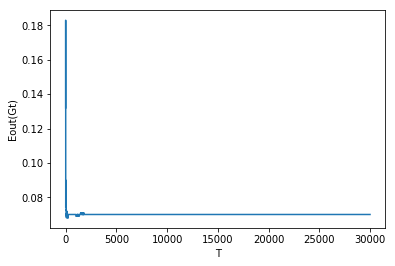

In [32]:
#11,12,13
import numpy as np
from graphviz import Graph
import matplotlib.pyplot as plt

train_data = np.loadtxt('hw3_train.dat.txt')
test_data = np.loadtxt('hw3_test.dat.txt')
train_x = train_data[:,0:-1]
train_y = train_data[:,-1]
test_x = test_data[:,0:-1]
test_y = test_data[:,-1]

class node():
    def __init__(self,threshold,index,value=None):
        self.threshold = threshold
        self.index = index
        self.value = value
        self.leftNode = None
        self.rightNode = None

def gini_index(Y):
    length = len(Y)
    if length == 0:
        return 1
    else:
        return 1 - (np.sum(Y==1)/length)**2 - (np.sum(Y==-1)/length)**2
        
def decision_stump(train_x,train_y):
    error = train_y.shape[0]
    for i in range(len(train_x[0])):
        sort_array = np.sort(train_x[:,i])
        sort_array2 = []
        sort_array2 = np.append(sort_array[1:],0)
        threshold=[]
        threshold = np.append(-1*float("inf"),((sort_array + sort_array2)/2)[:-1])
        threshold = np.append(threshold,float("inf"))
        for theta in threshold:
            Y1 = train_y[train_x[:,i] < theta]
            Y2 = train_y[train_x[:,i] >= theta]
            impurity = Y1.shape[0]*gini_index(Y1)+Y2.shape[0]*gini_index(Y2)
            if error > impurity:
                error = impurity
                s = theta
                feature_index = i
    return (feature_index,s)
        

def stop_cut(X, Y):
    if gini_index(Y)==0 or X.shape[0]==1 or np.sum(X!=X[0])==0:
        return True
    else:
        return False

def decision_tree(train_x,train_y):
    if stop_cut(train_x,train_y):
        tree_node = node(None,None,train_y[0])
        return tree_node
    feature_index,s = decision_stump(train_x,train_y)
    pos1 = train_x[:,feature_index] < s 
    pos2 = train_x[:,feature_index] >= s
    left_train_x = train_x[pos1,:]
    left_train_y = train_y[pos1]
    right_train_x = train_x[pos2,:]
    right_train_y = train_y[pos2]
    tree_node = node(s,feature_index)
    tree_node.leftNode = decision_tree(left_train_x,left_train_y)
    tree_node.rightNode = decision_tree(right_train_x,right_train_y)
    return tree_node

def draw_tree(root,node,leaf):
    if root.value ==None:
        node += 1
        graph.node(name='%d' %(node),label="%d;%5f" %(root.index+1,root.threshold))
        if root.leftNode != None:
            node,leaf = draw_tree(root.leftNode,node,leaf)
        if root.rightNode != None:
            node,leaf = draw_tree(root.rightNode,node,leaf)
    else:
        leaf += 1
        graph.node(name='l%d' %leaf,label="class = %d" %root.value)
    return node,leaf

def predict_tree(root,X):
    if root.value != None:
        return root.value
    threshold = root.threshold; index = root.index
    if X[index] < threshold:
        return predict_tree(root.leftNode,X)
    else:
        return predict_tree(root.rightNode,X)


def error(train_x,train_y,tree):
    predict = np.zeros(train_y.shape)
    for num in range(train_x.shape[0]):
        predict[num] = predict_tree(tree, train_x[num,:])
    return predict

tree = decision_tree(train_x,train_y)
graph = Graph('tree', format='svg')
internal_num,leaf = draw_tree(tree,0,0)

graph.edge('1','2')
graph.edge('2','3')
graph.edge('3','l1')
graph.edge('3','l2')
graph.edge('2','4')
graph.edge('4','5')
graph.edge('5','6')
graph.edge('6','l3')
graph.edge('6','l4')
graph.edge('5','7')
graph.edge('7','l5')
graph.edge('7','l6')
graph.edge('4','8')
graph.edge('8','9')
graph.edge('9','l7')
graph.edge('9','l8')
graph.edge('8','l9')
graph.edge('1','10')
graph.edge('10','l10')
graph.edge('10','l11')

predict_y = error(train_x,train_y,tree)
E_in = np.sum(predict_y!=train_y)/train_y.shape[0]
print("E in = %f" %E_in)
predict_y = error(test_x,test_y,tree)
E_out = np.sum(predict_y!=test_y)/test_y.shape[0]
print("E out = %f" %E_out)


#13
def purning_tree(X,Y,root,set_height,start_height,Error):
    if root.value == None and start_height < set_height:
        start_height += 1
        threshold = root.threshold; index = root.index
        X_left = X[X[:,index] < threshold,:]
        Y_left = Y[X[:,index] < threshold]
        X_right = X[X[:,index] >= threshold,:]
        Y_right = Y[X[:,index] >= threshold]
        Error = purning_tree(X_left,Y_left,root.leftNode,set_height,start_height,Error)
        Error = purning_tree(X_right,Y_right,root.rightNode,set_height,start_height,Error)
    elif root.value == None and start_height == set_height:
        if np.sum(Y) >= 0:
            error = np.sum(np.ones(np.shape(Y)) != Y)
            #print(error)
            return Error+error
        else:
            error = np.sum(-1*np.ones(np.shape(Y)) != Y)
            #print(error)
            return Error+error
    elif root.value != None and start_height <= set_height:
        error = np.sum(root.value * np.ones(np.shape(Y)) != Y)
        #print(error)
        return Error+error
    return Error

def purning_error(total_height,X,Y):
    error = []
    for height in range(total_height):
        error.append(purning_tree(X,Y,tree,height,0,0))
    Error = np.array(error)/Y.shape[0]
    return Error

total_height = 6
E_in = purning_error(total_height,train_x,train_y)
E_out = purning_error(total_height,test_x,test_y)

plt.plot(E_in,color='purple',linewidth=1,linestyle='-',label="E in")
plt.plot(E_out,color='red',linewidth=1,linestyle='-',label="E out")
plt.xlabel('Height')
plt.ylabel('Error')
plt.legend(loc='upper right')
plt.savefig('Q13.jpg')
plt.show()

#14,15
def bagging(X,Y,rate):
    pos = np.random.randint(0, X.shape[0],size = int(X.shape[0]*rate))
    return X[pos, :], Y[pos]

def random_forest(X, Y,iteration,rate):
    Treenode = []
    for i in range(iteration):
        bag_train_x, bag_train_y = bagging(X, Y,rate)
        node = decision_tree(bag_train_x, bag_train_y)
        Treenode.append(node)
    return Treenode

T = 30000
E_in = []
G_E_in = []
Gt = []
G_E_out = []
Gt_out = []
#build tree
treeArray = random_forest(train_x, train_y,T,0.8)

for i in range(T):
    predict_y = error(train_x,train_y,treeArray[i])
    G_predict_y = np.reshape(error(train_x,train_y,treeArray[i]),(-1,1))
    G_out_predict_y = np.reshape(error(test_x,test_y,treeArray[i]),(-1,1))
    if i==0:
        Gt = G_predict_y
        Gt_out = G_out_predict_y
    else:
        Gt = np.concatenate((Gt,G_predict_y),axis = 1)
        Gt_out = np.concatenate((Gt_out,G_out_predict_y),axis = 1)
    E_in.append(np.sum(predict_y!=train_y)/train_y.shape[0])
    G_E_in.append(np.sum(np.sign(np.sum(Gt,axis=1)) != train_y)/train_y.shape[0])
    G_E_out.append(np.sum(np.sign(np.sum(Gt_out,axis=1)) != test_y)/test_y.shape[0]) 
    
plt.hist(E_in,color='green')
plt.xlabel('Ein(gt)')
plt.ylabel('Count')
plt.savefig('Q14.jpg')
plt.show()

plt.plot(G_E_in)
plt.xlabel('T')
plt.ylabel('Ein(Gt)')
plt.savefig('Q15.jpg')
plt.show()

plt.plot(G_E_out)
plt.xlabel('T')
plt.ylabel('Eout(Gt)')
plt.savefig('Q16.jpg')
plt.show()